# CIFAR-10 Classification - Result Analysis
 
- Computes predictions and per-sample losses  
- Plots:
  - Confusion matrix  
  - Training vs test loss  
  - Training vs test accuracy  
- Displays:
  - 10 random correctly classified images  
  - 10 worst misclassified images (highest loss)  

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms

from utils import CIFAR10_dataset, ICCNN


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading the test dataset

In [3]:
# CIFAR-10 normalization used during training
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load test dataset
test_dataset = CIFAR10_dataset(partition="test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)



Loading CIFAR10  test  Dataset...
	Total Len.:  10000 
 --------------------------------------------------


## Original images

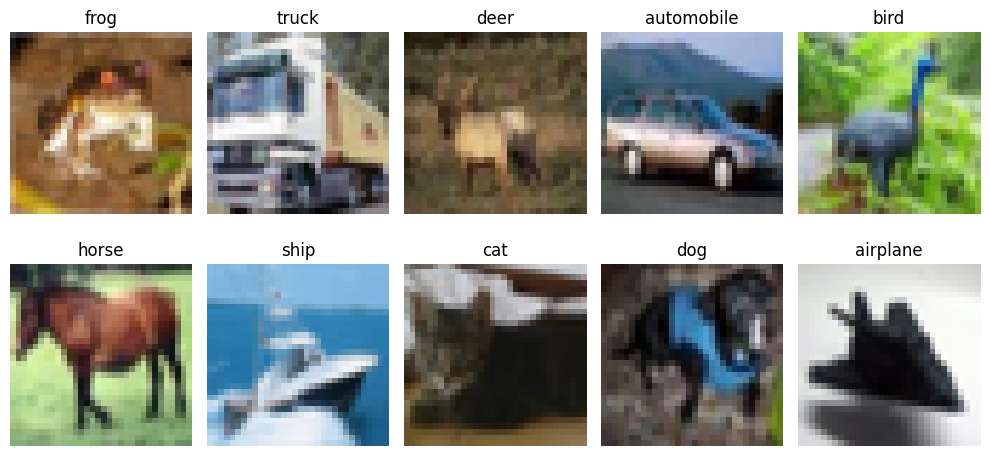

In [4]:
# For reproducibility 
torch.manual_seed(0)

# CIFAR-10 class names in standard order
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 train set 
base_dataset = torchvision.datasets.CIFAR10(
    root=".data",
    train=True,
    download=True,
    transform=None
)

# Collect one example per class
example_imgs = []
example_labels = []

seen_classes = set()
for img, label in base_dataset:
    if label not in seen_classes:
        example_imgs.append(img)        # PIL Image
        example_labels.append(label)    # int 0–9
        seen_classes.add(label)
    if len(seen_classes) == 10:
        break

# Plot 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for i, (img, label) in enumerate(zip(example_imgs, example_labels)):
    ax = axes[i]
    ax.imshow(np.array(img))
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


## Augmented images

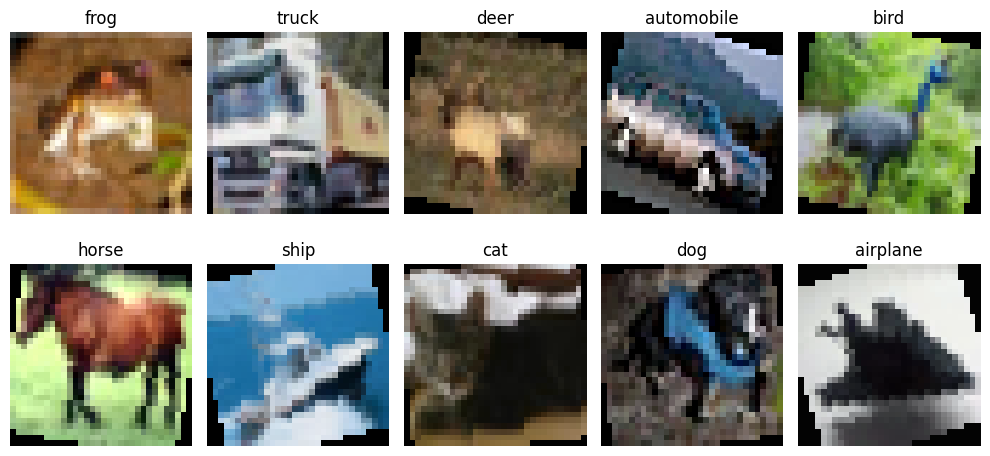

In [5]:
from torchvision.transforms import (
    RandomRotation, RandomHorizontalFlip, ColorJitter,
    RandomAdjustSharpness, ToTensor, Normalize, Compose
)

mean = [0.4914, 0.4822, 0.4465]
std  = [0.247, 0.243, 0.261]

train_transform = Compose([
    RandomRotation(20),
    RandomHorizontalFlip(0.1),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    ToTensor(),
    Normalize(mean, std),
])

# Helper to denormalize back to [0,1] for display
mean_tensor = torch.tensor(mean).view(3, 1, 1)
std_tensor  = torch.tensor(std).view(3, 1, 1)

def denormalize(img_tensor):
    """
    img_tensor: (3, H, W) normalized tensor
    returns: (H, W, 3) numpy array in [0,1]
    """
    img = img_tensor * std_tensor + mean_tensor
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

# Apply transform
transformed_imgs = []
for pil_img in example_imgs:
    t_img = train_transform(pil_img)   # (3,H,W) tensor, normalized
    transformed_imgs.append(t_img)

# Plot 2×5 grid of transformed images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for i, (t_img, label) in enumerate(zip(transformed_imgs, example_labels)):
    ax = axes[i]
    img_np = denormalize(t_img)
    ax.imshow(img_np)
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


## Loading the best prediction model

In [6]:
num_classes = 10
net = ICCNN(num_classes)
state_dict = torch.load("models/best_model.pt", map_location=device)
net.load_state_dict(state_dict)
net.to(device)
net.eval()

ICCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxP

## Evaluation: Collect Predictions, Labels, Images, Losses

In [7]:
# Per-sample loss (we need indices, not one-hot)
criterion_per_sample = nn.CrossEntropyLoss(reduction="none")

all_images = []
all_labels = []
all_preds = []
all_losses = []

with torch.no_grad():
    for batch in test_dataloader:
        images = batch["img"].to(device)
        labels = batch["label"].to(device)

        # If labels are one-hot, convert to indices
        if labels.ndim == 2:
            labels_idx = torch.argmax(labels, dim=1)
        else:
            labels_idx = labels

        outputs = net(images)
        preds = torch.argmax(outputs, dim=1)
        losses = criterion_per_sample(outputs, labels_idx)

        all_images.append(images.cpu())
        all_labels.append(labels_idx.cpu())
        all_preds.append(preds.cpu())
        all_losses.append(losses.cpu())

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_preds = torch.cat(all_preds, dim=0)
all_losses = torch.cat(all_losses, dim=0)

print("Images:", all_images.shape)
print("Labels:", all_labels.shape)
print("Preds:", all_preds.shape)
print("Losses:", all_losses.shape)


/home/hkppp/Classes/CIFAR10/.venv/lib/python3.12/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Images: torch.Size([10000, 3, 32, 32])
Labels: torch.Size([10000])
Preds: torch.Size([10000])
Losses: torch.Size([10000])


## Training vs Test Loss && Training vs Test Accuracy 

In [8]:
history = torch.load("models/training_history.pt")
history.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc'])

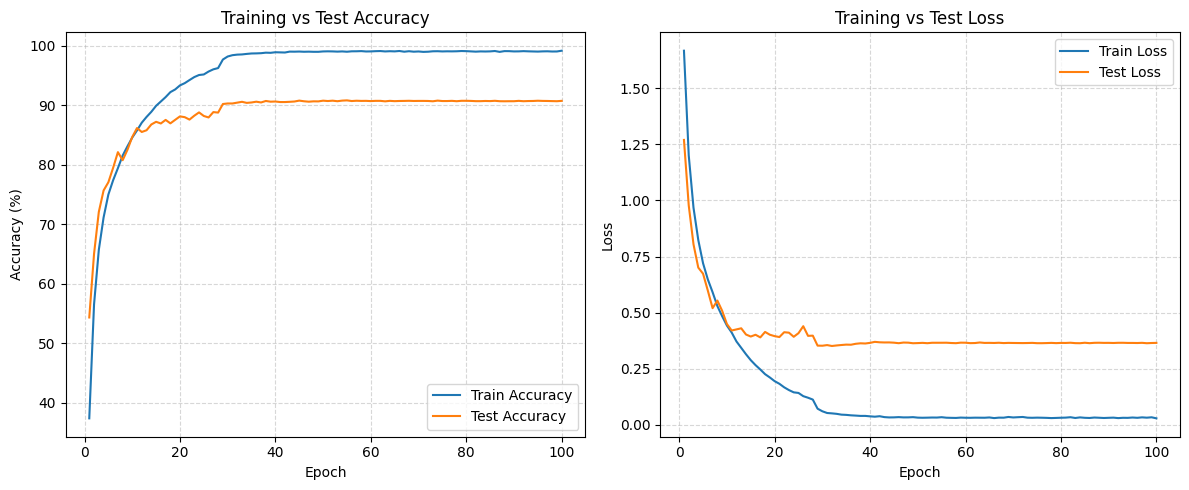

In [9]:
# Make sure everything is plain CPU arrays for matplotlib
def to_cpu_array(x):
    x = torch.as_tensor(x)      # handles list, numpy, or tensor
    return x.detach().cpu().numpy()

train_loss = to_cpu_array(history["train_loss"])
test_loss  = to_cpu_array(history["test_loss"])
train_acc  = to_cpu_array(history["train_acc"])
test_acc   = to_cpu_array(history["test_acc"])

epochs = len(train_loss)
epochs_range = range(1, epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Right: Loss ----
ax_loss = axes[1]
ax_loss.plot(epochs_range, train_loss, label="Train Loss")
ax_loss.plot(epochs_range, test_loss,  label="Test Loss")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Training vs Test Loss")
ax_loss.legend()
ax_loss.grid(True, linestyle="--", alpha=0.5)

# ---- Left: Accuracy ----
ax_acc = axes[0]
ax_acc.plot(epochs_range, train_acc, label="Train Accuracy")
ax_acc.plot(epochs_range, test_acc,  label="Test Accuracy")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy (%)")
ax_acc.set_title("Training vs Test Accuracy")
ax_acc.legend()
ax_acc.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
print("Max train Acc:", max(train_acc))
print("Max test Acc:", max(test_acc))   

Max train Loss: 1.6671233
Min test Loss: 0.35170078
Max train Acc: 99.146
Max test Acc: 90.8


## Confusion Matrix Plot

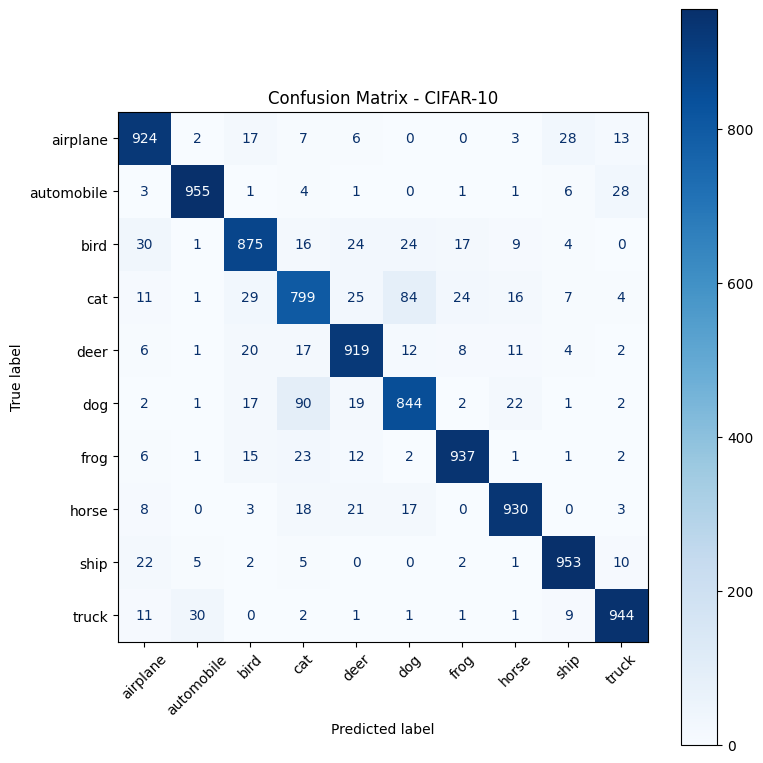

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix - CIFAR-10")
plt.tight_layout()
plt.show()


## Show 10 Random Correct Predictions

In [12]:
correct_mask = (all_preds == all_labels)
correct_indices = torch.nonzero(correct_mask).squeeze(1)

num_correct_to_show = min(10, correct_indices.numel())
num_correct_to_show


10

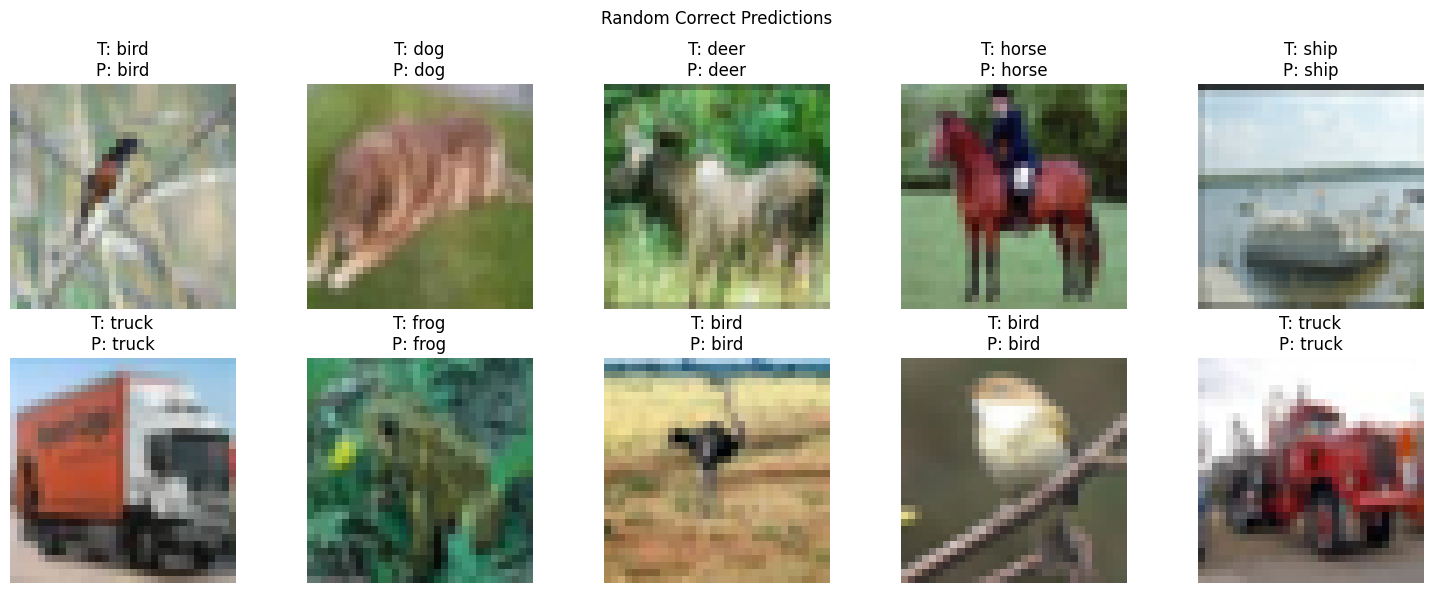

In [13]:
mean_tensor = torch.tensor(mean).view(3, 1, 1)
std_tensor = torch.tensor(std).view(3, 1, 1)

def denormalize(img_tensor):
    """
    img_tensor: (3, H, W) normalized with mean/std.
    returns: (3, H, W) in [0, 1] range
    """
    img = img_tensor * std_tensor + mean_tensor
    return img.clamp(0, 1)

if num_correct_to_show == 0:
    print("No correct predictions? That seems wrong - check labels/model.")
else:
    perm = torch.randperm(correct_indices.numel())[:num_correct_to_show]
    chosen_correct = correct_indices[perm]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(chosen_correct):
        img = denormalize(all_images[idx])
        img_np = img.permute(1, 2, 0).numpy()

        ax = axes[i]
        ax.imshow(img_np)
        true_cls = class_names[all_labels[idx].item()]
        pred_cls = class_names[all_preds[idx].item()]
        ax.set_title(f"T: {true_cls}\nP: {pred_cls}")
        ax.axis("off")

    # Hide any unused axes if num_correct_to_show < 10
    for j in range(num_correct_to_show, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Random Correct Predictions")
    plt.tight_layout()
    plt.show()


## Show 10 Worst Misclassified Predictions (Highest Loss)

In [14]:
wrong_mask = (all_preds != all_labels)
wrong_indices = torch.nonzero(wrong_mask).squeeze(1)

num_wrong = wrong_indices.numel()
num_wrong


920

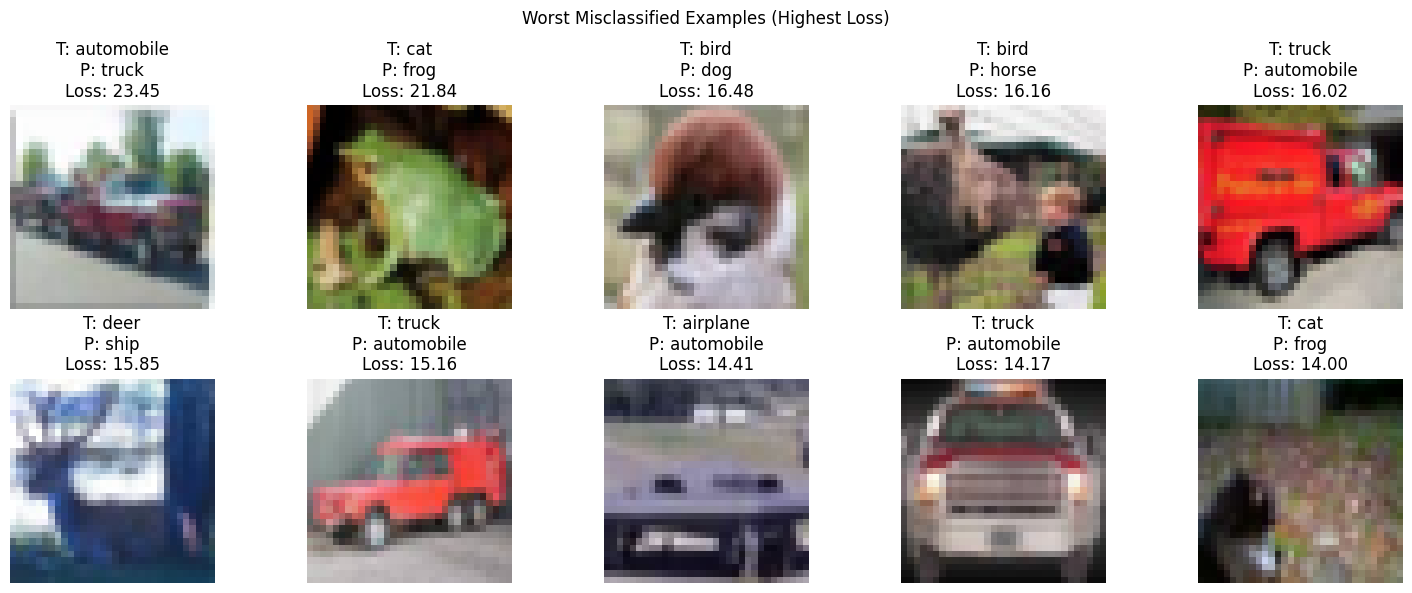

In [15]:
if num_wrong == 0:
    print("Perfect accuracy on test set - no misclassified examples to show.")
else:
    wrong_losses = all_losses[wrong_indices]
    k = min(10, num_wrong)
    worst_vals, worst_idx_sorted = torch.topk(wrong_losses, k=k, largest=True)
    worst_sample_indices = wrong_indices[worst_idx_sorted]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(worst_sample_indices):
        img = denormalize(all_images[idx])
        img_np = img.permute(1, 2, 0).numpy()

        ax = axes[i]
        ax.imshow(img_np)

        true_cls = class_names[all_labels[idx].item()]
        pred_cls = class_names[all_preds[idx].item()]
        loss_val = all_losses[idx].item()

        ax.set_title(f"T: {true_cls}\nP: {pred_cls}\nLoss: {loss_val:.2f}")
        ax.axis("off")

    # Hide any unused axes if k < 10
    for j in range(k, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Worst Misclassified Examples (Highest Loss)")
    plt.tight_layout()
    plt.show()
